In [10]:
import re
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
import joblib
from step import *
import plotly
from sklearn import ensemble
# from pycaret.regression import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [11]:
df_alg = pd.read_csv("../../data/joao-pessoa-aluguel.csv")
df1 = pd.read_csv("../../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)

In [12]:
df3 = pd \
    .read_csv('../../data/aluguel_social_jp.csv', delimiter=';') \
    .query('`ANO DO PAGAMENTO` == 2023') \
    .dropna(subset=['BAIRRO']) \
    .rename(columns={'BAIRRO': 'bairro'}) \
    .assign(bairro=lambda x: x.bairro.str.strip().str.title()) \
    .replace(
        {
            r'M[AaNnGg]([a-zA-Z])*\sI': 'Mangabeira I',
            r'M[AaNnGg]([a-zA-Z])*\sII': 'Mangabeira II',
            r'M[AaNnGg]([a-zA-Z])*\sIII': 'Mangabeira III',
            r'M[AaNnGg]([a-zA-Z])*\sIV': 'Mangabeira IV',
            r'M[AaNnGg]([a-zA-Z])*\sVii': 'Mangabeira IV',
            'Mangabeira Iv': 'Mangabeira IV',
            'Mangabeira Iii': 'Mangabeira III',
            'Mangabeira Ii': 'Mangabeira II',
            'Mangabeira Vi': 'Mangabeira VI',
            'Mangabeira Vii': 'Mangabeira VII',
            'Mangabeira Viii': 'Mangabeira VIII',
            'Mangabeira, Viii': 'Mangabeira VIII',
            'Mangabeira 8': 'Mangabeira VIII',
            r'M[AaNnGg]([a-zA-Z])*': 'Mangabeira',
            r'Varad([a-zA-Z]).*': 'Varadouro',
            'Jd Veneza': 'Jardim Veneza',
            'Jd Cidade Universitaria': 'Jardim Cidade Universitaria',
            'Mangabeira \( Aratu\)': 'Mangabeira',
            'Monsenhor Mangabeira': 'Mangabeira',
            'Mangabeira 1': 'Mangabeira',
            'Mangabeira \(Aratu\)': 'Mangabeira',
            'Bairro Dos Estados': 'Estados',
            'Mangabeira 6': 'Mangabeira VI',
            'Cristo': 'Cristo Redentor',
        },
        regex=True
    ) \
    .replace(
        {
            'Monsenhor Mangabeira': 'Mangabeira',
            'Baixo Roger': 'Roger',
            'Funcionarios 2': 'Funcionarios II a IV',
            'Cristo Redentor Redentor': 'Cristo Redentor',
            'Baixo Roger ( Vila Lula\nLucena)': 'Roger',
            'Collinas Do Sul': 'Colinas do Sul',
            'Cidade Verde - Bairro Das Industrias': 'Bairro das Industrias',
            'Cristo Redentor/Vale Das Palmeiras': 'Cristo Redentor',
            'Biarro Das Industria': 'Bairro das Industrias',
            'Altiplano 2': 'Altiplano',
            'Dos Ipes': 'Bairro Dos Ipes',
            'Aeroclube/Bessa': 'Aeroclube',
            'Bairro Sao Jose': 'Sao Jose',
            'B. Industrias': 'Bairro das Industrias',
            'Industrias': 'Bairro das Industrias',
            'B Das Industrias': 'Bairro das Industrias',
            'Funcionarios Ii': 'Funcionarios II a IV',
            'Bela Vista/Cristo Redentor': 'Cristo Redentor',
            'Sao Jose/ Barreira': 'Sao Jose',
            'B. Dos Estados': 'Estados',
            '13 De Mangabeira': 'Mangabeira',
            'Cristro Redentor': 'Cristo Redentor',
            'Funcionario Iii': 'Funcionarios II a IV',
            'Gervasio Mangabeira': 'Mangabeira',
            'Ipes': 'Bairro Dos Ipes',
            'B. Das Industrias': 'Bairro das Industrias',
            'Joao Paulo Ii': 'Joao Paulo II',
            'Padreze': 'Padre Ze',
            'Valentina I': 'Valentina',
            'B. Dos Novais': 'Bairro dos novais',
            'Novais': 'Bairro dos novais',
            'Treze De Mangabeira': 'Mangabeira',
            'Estados': 'Bairro dos estados'
        }
    ) \
    .reset_index(drop=True)
df3 = df3.replace({'Estados': 'bairro dos estados'})

df3 = df3.assign(bairro=lambda x: x.bairro.str.lower().str.replace(' ', '_')) \
    .groupby(['bairro'], as_index=False).size() \
    .rename(columns={'size': 'qnt_beneficio'})

In [13]:
def extract_location(address):
    pattern_joao_pessoa = re.compile(r'(.+),\s*João Pessoa$')
    match_joao_pessoa = pattern_joao_pessoa.search(address)

    if match_joao_pessoa:
        return match_joao_pessoa.group(1).strip()

    pattern_general = re.compile(r',\s*([^,]+)$')
    match_general = pattern_general.search(address)

    if match_general:
        return match_general.group(1).strip()

    return None

def clear_addr(x):
    pattern = re.compile(r'[-,\s]*(.*?)\s*,?\s*João Pessoa - PB')
    extracted_parts = [pattern.search(address).group(1) if pattern.search(address) else None for address in x]

    return [re.sub(r'^.* - ', '', address) for address in extracted_parts]

df1 = df1 \
    .assign(
        bairro=lambda x: clear_addr(x.endereco),
        error=lambda x: list(map(lambda y: ('Rua' in y) or (y == ''), x.bairro.tolist())),
    ) \
    .query('error == False') \
    .reset_index(drop=True) \
    .drop(columns=['error']) \
    .replace(
        {
            'Valentina Figueiredo': 'Valentina de Figueiredo',
            'Jardim Treze de Maio': 'Jardim 13 de Maio'
        }
    )

df2 = df2.assign(bairro=lambda x: [extract_location(address) for address in x.endereco])

df_alg = df_alg \
    .assign(bairro=lambda x: clear_addr(x.endereco)) \
    .replace({
        'Altiplano Cabo Branco': 'Altiplano',
        'ipes': 'Bairro dos Ipes',
        'Estados': 'Bairro dos estados',
        'Jardim Treze de Maio': 'Jardim 13 de Maio',
        'Ipês': 'Bairro dos Ipes'
    })

df_alg = df_alg \
    .assign(
        bairro=lambda x: x.bairro.str.normalize('NFKD') \
            .str.encode('ascii', errors='ignore') \
            .str.decode('utf-8') \
            .str.lower() \
            .str.replace(' ', '_')
    ) \
    .rename(
        columns={
            'area': 'area_aluguel',
            'valor': 'valor_aluguel',
            # 'vaga': 'vaga_aluguel',
            # 'quarto': 'quarto_aluguel',
            # 'banheiro': 'banheiro_aluguel'
            }
        ) \
    .groupby(['bairro'], as_index=False) \
    [['area_aluguel', 'valor_aluguel']] \
    .median()

In [14]:
df = pd.concat([df1, df2]) \
    .drop_duplicates('id') \
    .reset_index(drop=True) \
    .drop(columns=['id', 'url']) \
    .query('bairro != "Monsenhor Magno"') \
    .replace(
        {
            'Altiplano Cabo Branco': 'Altiplano',
            'Estados': 'Bairro dos estados',
            'Ipês': 'Bairro dos ipes',
            'Industrias': 'Bairro das Industrias',
            'Cidade dos Funcionarios II': 'Funcionários II a IV',
            'Cidade dos Colibris': 'Colibris',
            'Conjunto Pedro Gondim': 'Pedro gondim',
            'José Américo de Almeida': 'jose americo'
        }
    )

df = df \
    .assign(bairro=lambda x: x.bairro.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ', '_').str.lower()) \
    .merge(df_alg, on='bairro', how='left') \
    .merge(df3, on='bairro', how='left') \
    .reset_index(drop=True)

## Cleaning

In [15]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [16]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas', 'casas_comerciais']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [17]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [18]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=['valor_cut']).reset_index(drop=True)
test_df = test_df.drop(columns=['valor_cut']).reset_index(drop=True)

df.drop(columns=["valor_cut"]).to_csv("../../data/cleaned/jp_limpo.csv", index=False)
train_df.to_csv("../../data/cleaned/train.csv", index=False)
test_df.to_csv("../../data/cleaned/test.csv", index=False)

train_df = train_df.drop(columns=['qnt_beneficio'])
test_df = test_df.drop(columns=['qnt_beneficio'])

## Missing values

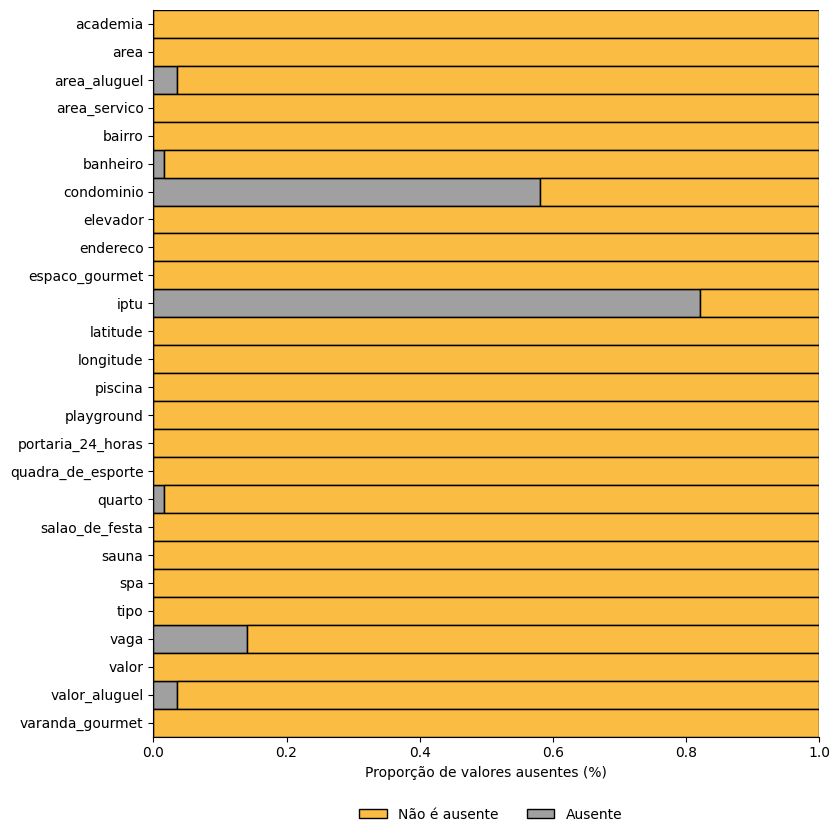

In [19]:
g_missing = sns.displot(
    data=train_df.isnull() \
        .melt(value_name="Valores ausentes") \
        .replace([False, True], ["Não é ausente", "Ausente"]) \
        .groupby(["variable", "Valores ausentes"]).size() \
        .reset_index(name="count") \
        .assign(
            proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
        ),
    y="variable",
    hue="Valores ausentes",
    weights="proportion",
    multiple="fill",
    height=8,
    aspect=1.1,
    palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
    )

sns.move_legend(obj=g_missing, loc="upper center",
                bbox_to_anchor=(.5, -.0001), ncol=2, title="")
g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

### Some functions

In [20]:
def display_scores(scores, confidence=0.95):

    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrão:", scores.std())

In [21]:
def plot_error(scores):
    ax, fig = plt.subplots(figsize=(20, 20))
    lineplot = sns.lineplot(y=scores, x=list(range(1, 11)))
    plt.title('Raiz do erro quadrático médio', fontdict={'fontsize': 18})
    plt.xlabel('CV', fontdict={'fontsize': 14})
    plt.ylabel('RMSE', fontdict={'fontsize': 14})
    lineplot.set_xticklabels(lineplot.get_xticklabels(), fontdict={'fontsize': 13})
    lineplot.set_yticklabels(lineplot.get_yticklabels(), fontdict={'fontsize': 13})
    plt.show()

In [22]:
def plot_predict(model):
    plt.figure(figsize=(20, 20))
    scatter = sns.scatterplot(y=np.exp(model.predict(test_df.drop('valor', axis=1))), x=np.exp(test_df.valor) - 1)
    plt.title('Predições VS Valores Reais', fontdict={'fontsize': 18})
    plt.xlabel('Valores Reais', fontdict={'fontsize': 13})
    plt.ylabel('Predições', fontdict={'fontsize': 13})
    plt.show()

In [23]:
gbr_native = ensemble.GradientBoostingRegressor()
lgbm_native = LGBMRegressor()
rf_native = ensemble.RandomForestRegressor()
xgboost_native = XGBRegressor()

## Modeling 

In [24]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [25]:
drop_cols_fit = ['endereco', 'bairro', 'iptu', 'condominio']

pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("new_feature", BedAreaBedToi()),
     ("ordinal_encoder", OrdEncoder()),
     ("onehot_encoder", OneEncoder()),
     ("log_transform", LogTransform()),
     ("scaling", Scale())
    ])
pipe_jp.fit(train_df.drop(columns=drop_cols_fit))

Pipeline(steps=[('imputer', Imputer()), ('new_feature', BedAreaBedToi()),
                ('ordinal_encoder', OrdEncoder()),
                ('onehot_encoder', OneEncoder()),
                ('log_transform', LogTransform()), ('scaling', Scale())])

In [26]:
train_df_novo = pipe_jp.transform(train_df.drop(columns=drop_cols_fit))
test_df_novo = pipe_jp.transform(test_df.drop(columns=drop_cols_fit))

In [17]:
# s = setup(train_df_novo, target='valor')
# best = compare_models()

## Optim

### LGBM

In [119]:
def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    max_depth = trial.suggest_int('max_depth', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, .01)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [120]:
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2024-09-10 19:23:09,687] A new study created in memory with name: no-name-34f1c535-9f59-47ce-8718-377b675d3778


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] [LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027471 seconds.
You can set `force_col_wise=true` to remove the overhead.
Auto-choosing row-wise multi-threading, the overhead of testing was 0.016206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Start training from score 13.051175
[LightGBM] [Info] Start training from score 

In [125]:
best_params_lgbm = {
    'num_leaves': 247,
    'max_depth': 299,
    'learning_rate': 0.009035568789398086,
    'n_estimators': 1798}

In [127]:
joblib.dump(study_lgbm, 'study_pkl/study_lgbm.pkl')

['study_pkl/study_lgbm.pkl']

### Random Forest

In [43]:
forest = ensemble.RandomForestRegressor(
    n_estimators=1500,
    random_state=42,
    max_depth=100,
    max_features="sqrt",
    n_jobs=1)

In [44]:
forest.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1500,
                      n_jobs=1, random_state=42)

In [45]:
forest.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8660368903247242

In [46]:
test_df_clone = test_df.copy()

In [47]:
preds = forest.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds'] = preds

<Axes: xlabel='preds', ylabel='valor'>

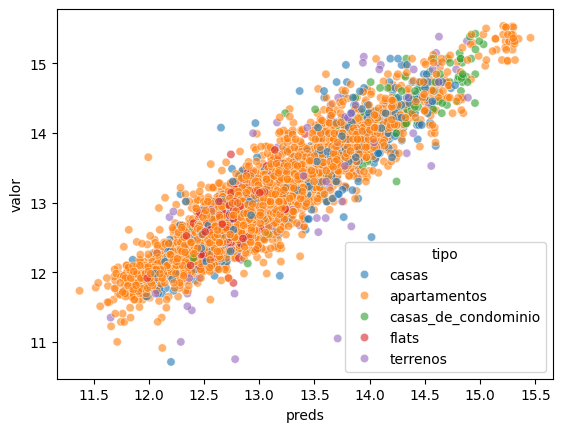

In [48]:
sns.scatterplot(data=test_df_clone, x='preds', y='valor', hue='tipo', alpha=.6)

In [27]:
def objective_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int(name='n_estimators', low=1, high=1000),
        max_depth=trial.suggest_int(name='max_depth', low=20, high=1000),
        max_features='sqrt',
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params,
        n_jobs=3
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop("valor", axis=1),
        y=train_df_novo.valor,
        scoring="neg_mean_squared_error",
        n_jobs=3,
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [29]:
joblib.dump(study, 'study_pkl/study_rf.pkl')

['study_pkl/study_rf.pkl']

In [28]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_rf, n_trials=100, show_progress_bar=True)

[I 2024-09-11 22:49:19,647] A new study created in memory with name: no-name-b9bcb42c-6caa-474e-9f40-a58c2912094a


  0%|          | 0/100 [00:00<?, ?it/s]

/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 22:50:38,696] Trial 0 finished with value: 1.3004480838192738 and parameters: {'n_estimators': 287, 'max_depth': 862}. Best is trial 0 with value: 1.3004480838192738.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 22:53:46,204] Trial 1 finished with value: 1.29967715517818 and parameters: {'n_estimators': 687, 'max_depth': 490}. Best is trial 1 with value: 1.29967715517818.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 22:57:29,496] Trial 2 finished with value: 1.2996182581633962 and parameters: {'n_estimators': 851, 'max_depth': 840}. Best is trial 2 with value: 1.2996182581633962.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 22:59:52,412] Trial 3 finished with value: 1.2997950505443376 and parameters: {'n_estimators': 593, 'max_depth': 609}. Best is trial 2 with value: 1.2996182581633962.
[I 2024-09-11 23:01:16,967] Trial 4 finished with value: 1.3001112012078295 and parameters: {'n_estimators': 366, 'max_depth': 577}. Best is trial 2 with value: 1.2996182581633962.
[I 2024-09-11 23:02:22,013] Trial 5 finished with value: 1.300511519645649 and parameters: {'n_estimators': 284, 'max_depth': 139}. Best is trial 2 with value: 1.2996182581633962.
[I 2024-09-11 23:02:37,604] Trial 6 finished with value: 1.3028724339330906 and parameters: {'n_estimators': 67, 'max_depth': 213}. Best is trial 2 with value: 1.2996182581633962.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 23:18:09,791] Trial 7 finished with value: 1.299583984904427 and parameters: {'n_estimators': 984, 'max_depth': 980}. Best is trial 7 with value: 1.299583984904427.
[I 2024-09-11 23:19:21,063] Trial 8 finished with value: 1.3006888130927843 and parameters: {'n_estimators': 215, 'max_depth': 938}. Best is trial 7 with value: 1.299583984904427.
[I 2024-09-11 23:20:06,085] Trial 9 finished with value: 1.3007860380558305 and parameters: {'n_estimators': 197, 'max_depth': 651}. Best is trial 7 with value: 1.299583984904427.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 23:24:52,187] Trial 10 finished with value: 1.2995807065274165 and parameters: {'n_estimators': 995, 'max_depth': 359}. Best is trial 10 with value: 1.2995807065274165.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-11 23:49:38,536] Trial 11 finished with value: 1.2995803419604244 and parameters: {'n_estimators': 996, 'max_depth': 322}. Best is trial 11 with value: 1.2995803419604244.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:13:51,569] Trial 12 finished with value: 1.29958357014105 and parameters: {'n_estimators': 985, 'max_depth': 353}. Best is trial 11 with value: 1.2995803419604244.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:17:37,168] Trial 13 finished with value: 1.2994631241095669 and parameters: {'n_estimators': 784, 'max_depth': 33}. Best is trial 13 with value: 1.2994631241095669.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:22:03,764] Trial 14 finished with value: 1.2996604389900583 and parameters: {'n_estimators': 792, 'max_depth': 56}. Best is trial 13 with value: 1.2994631241095669.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:25:10,314] Trial 15 finished with value: 1.2968341239844148 and parameters: {'n_estimators': 778, 'max_depth': 23}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:27:04,068] Trial 16 finished with value: 1.2990768248795286 and parameters: {'n_estimators': 491, 'max_depth': 29}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:29:00,802] Trial 17 finished with value: 1.2999876266642836 and parameters: {'n_estimators': 485, 'max_depth': 201}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:30:41,600] Trial 18 finished with value: 1.2971424005593368 and parameters: {'n_estimators': 490, 'max_depth': 21}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:33:14,905] Trial 19 finished with value: 1.299761196944646 and parameters: {'n_estimators': 619, 'max_depth': 163}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:34:55,811] Trial 20 finished with value: 1.3000934839311031 and parameters: {'n_estimators': 439, 'max_depth': 263}. Best is trial 15 with value: 1.2968341239844148.
[I 2024-09-12 00:37:08,991] Trial 21 finished with value: 1.2998408894907059 and parameters: {'n_estimators': 558, 'max_depth': 74}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:38:49,562] Trial 22 finished with value: 1.2991847082411123 and parameters: {'n_estimators': 418, 'max_depth': 30}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:41:39,601] Trial 23 finished with value: 1.2996774459907137 and parameters: {'n_estimators': 686, 'max_depth': 150}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:43:40,052] Trial 24 finished with value: 1.2999163899211563 and parameters: {'n_estimators': 510, 'max_depth': 273}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:46:35,391] Trial 25 finished with value: 1.2996797886537457 and parameters: {'n_estimators': 695, 'max_depth': 110}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:47:56,624] Trial 26 finished with value: 1.3001921583056988 and parameters: {'n_estimators': 348, 'max_depth': 425}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:49:58,437] Trial 27 finished with value: 1.2998958575936597 and parameters: {'n_estimators': 519, 'max_depth': 699}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:53:39,746] Trial 28 finished with value: 1.2971441415115013 and parameters: {'n_estimators': 901, 'max_depth': 24}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 00:57:34,967] Trial 29 finished with value: 1.2995920392725226 and parameters: {'n_estimators': 882, 'max_depth': 112}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:01:50,141] Trial 30 finished with value: 1.299591526532494 and parameters: {'n_estimators': 867, 'max_depth': 226}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:04:21,238] Trial 31 finished with value: 1.2983364796920758 and parameters: {'n_estimators': 621, 'max_depth': 28}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:07:42,201] Trial 32 finished with value: 1.299668647847507 and parameters: {'n_estimators': 770, 'max_depth': 98}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:10:04,683] Trial 33 finished with value: 1.296933170152314 and parameters: {'n_estimators': 646, 'max_depth': 23}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:12:50,623] Trial 34 finished with value: 1.299692695295486 and parameters: {'n_estimators': 701, 'max_depth': 772}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:24:02,669] Trial 35 finished with value: 1.299587626899879 and parameters: {'n_estimators': 901, 'max_depth': 178}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:27:15,143] Trial 36 finished with value: 1.2996825233479536 and parameters: {'n_estimators': 757, 'max_depth': 467}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:33:04,959] Trial 37 finished with value: 1.299581931513686 and parameters: {'n_estimators': 923, 'max_depth': 95}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:37:27,716] Trial 38 finished with value: 1.2996325975432224 and parameters: {'n_estimators': 815, 'max_depth': 280}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:40:06,457] Trial 39 finished with value: 1.299697142944444 and parameters: {'n_estimators': 668, 'max_depth': 537}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:43:53,817] Trial 40 finished with value: 1.299663062793002 and parameters: {'n_estimators': 739, 'max_depth': 137}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:46:37,957] Trial 41 finished with value: 1.2983455705245777 and parameters: {'n_estimators': 620, 'max_depth': 28}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:49:12,890] Trial 42 finished with value: 1.2998096791063136 and parameters: {'n_estimators': 570, 'max_depth': 80}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:51:44,968] Trial 43 finished with value: 1.2997648887764188 and parameters: {'n_estimators': 618, 'max_depth': 77}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:54:42,706] Trial 44 finished with value: 1.297021372757683 and parameters: {'n_estimators': 832, 'max_depth': 21}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 01:58:24,448] Trial 45 finished with value: 1.2996422105710281 and parameters: {'n_estimators': 831, 'max_depth': 138}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:14:57,678] Trial 46 finished with value: 1.2995830524399694 and parameters: {'n_estimators': 918, 'max_depth': 236}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:15:28,358] Trial 47 finished with value: 1.3049622044265201 and parameters: {'n_estimators': 43, 'max_depth': 191}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:20:22,232] Trial 48 finished with value: 1.2995771969651937 and parameters: {'n_estimators': 941, 'max_depth': 67}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:24:42,644] Trial 49 finished with value: 1.2996205639065763 and parameters: {'n_estimators': 839, 'max_depth': 127}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:27:27,832] Trial 50 finished with value: 1.296865728211315 and parameters: {'n_estimators': 731, 'max_depth': 23}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:31:27,093] Trial 51 finished with value: 1.2996759499716695 and parameters: {'n_estimators': 719, 'max_depth': 57}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:33:54,226] Trial 52 finished with value: 1.2972076135758908 and parameters: {'n_estimators': 659, 'max_depth': 24}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:38:05,846] Trial 53 finished with value: 1.2996508764938441 and parameters: {'n_estimators': 801, 'max_depth': 65}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:42:56,474] Trial 54 finished with value: 1.299621456958411 and parameters: {'n_estimators': 856, 'max_depth': 163}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:46:28,336] Trial 55 finished with value: 1.2973049785693092 and parameters: {'n_estimators': 961, 'max_depth': 20}. Best is trial 15 with value: 1.2968341239844148.
[I 2024-09-12 02:46:58,180] Trial 56 finished with value: 1.3014935817407085 and parameters: {'n_estimators': 125, 'max_depth': 874}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:50:57,278] Trial 57 finished with value: 1.299663062793002 and parameters: {'n_estimators': 739, 'max_depth': 115}. Best is trial 15 with value: 1.2968341239844148.
[I 2024-09-12 02:52:42,063] Trial 58 finished with value: 1.3001055138799658 and parameters: {'n_estimators': 440, 'max_depth': 318}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:53:49,840] Trial 59 finished with value: 1.3003018296605706 and parameters: {'n_estimators': 293, 'max_depth': 69}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:56:06,394] Trial 60 finished with value: 1.2998468035219566 and parameters: {'n_estimators': 544, 'max_depth': 201}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 02:59:39,426] Trial 61 finished with value: 1.299661546550364 and parameters: {'n_estimators': 679, 'max_depth': 46}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:01:57,205] Trial 62 finished with value: 1.2970711871281277 and parameters: {'n_estimators': 653, 'max_depth': 21}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:06:47,096] Trial 63 finished with value: 1.299667221725112 and parameters: {'n_estimators': 786, 'max_depth': 88}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:09:06,369] Trial 64 finished with value: 1.299806903489215 and parameters: {'n_estimators': 585, 'max_depth': 111}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:10:52,775] Trial 65 finished with value: 1.3000382494457476 and parameters: {'n_estimators': 456, 'max_depth': 53}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:12:22,096] Trial 66 finished with value: 1.3000629736578824 and parameters: {'n_estimators': 386, 'max_depth': 160}. Best is trial 15 with value: 1.2968341239844148.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:14:42,427] Trial 67 finished with value: 1.2968276888752437 and parameters: {'n_estimators': 650, 'max_depth': 22}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:16:50,719] Trial 68 finished with value: 1.299853155569862 and parameters: {'n_estimators': 541, 'max_depth': 626}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:19:27,793] Trial 69 finished with value: 1.2996820488066938 and parameters: {'n_estimators': 648, 'max_depth': 86}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:22:33,846] Trial 70 finished with value: 1.299683665705548 and parameters: {'n_estimators': 713, 'max_depth': 393}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:26:58,009] Trial 71 finished with value: 1.299585788686159 and parameters: {'n_estimators': 884, 'max_depth': 47}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:31:13,321] Trial 72 finished with value: 1.299657081546395 and parameters: {'n_estimators': 749, 'max_depth': 44}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:34:30,637] Trial 73 finished with value: 1.2996551197138309 and parameters: {'n_estimators': 795, 'max_depth': 115}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:37:13,819] Trial 74 finished with value: 1.2977171398120793 and parameters: {'n_estimators': 634, 'max_depth': 25}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:39:36,370] Trial 75 finished with value: 1.2997950505443376 and parameters: {'n_estimators': 593, 'max_depth': 83}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:41:33,302] Trial 76 finished with value: 1.2999806093195583 and parameters: {'n_estimators': 489, 'max_depth': 130}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:44:03,122] Trial 77 finished with value: 1.2970051869378825 and parameters: {'n_estimators': 715, 'max_depth': 21}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:46:51,186] Trial 78 finished with value: 1.2997034373039118 and parameters: {'n_estimators': 698, 'max_depth': 57}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:49:56,083] Trial 79 finished with value: 1.2996539003798904 and parameters: {'n_estimators': 729, 'max_depth': 996}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:53:22,444] Trial 80 finished with value: 1.2996841834762842 and parameters: {'n_estimators': 761, 'max_depth': 173}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:56:17,965] Trial 81 finished with value: 1.2973140664076748 and parameters: {'n_estimators': 820, 'max_depth': 20}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 03:58:57,256] Trial 82 finished with value: 1.299695689329028 and parameters: {'n_estimators': 665, 'max_depth': 97}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:03:29,149] Trial 83 finished with value: 1.2996097634462342 and parameters: {'n_estimators': 862, 'max_depth': 49}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:06:55,599] Trial 84 finished with value: 1.2996817279683435 and parameters: {'n_estimators': 768, 'max_depth': 139}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:09:16,869] Trial 85 finished with value: 1.2997712081035147 and parameters: {'n_estimators': 602, 'max_depth': 73}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:11:51,099] Trial 86 finished with value: 1.2997069739150084 and parameters: {'n_estimators': 641, 'max_depth': 97}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:14:35,579] Trial 87 finished with value: 1.299727539783817 and parameters: {'n_estimators': 686, 'max_depth': 41}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:16:39,894] Trial 88 finished with value: 1.2998978028251638 and parameters: {'n_estimators': 525, 'max_depth': 681}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:19:48,849] Trial 89 finished with value: 1.2972961462369494 and parameters: {'n_estimators': 891, 'max_depth': 20}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:25:53,145] Trial 90 finished with value: 1.299562994323953 and parameters: {'n_estimators': 948, 'max_depth': 69}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:28:04,993] Trial 91 finished with value: 1.297386787644412 and parameters: {'n_estimators': 567, 'max_depth': 20}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:30:49,453] Trial 92 finished with value: 1.2997031385377336 and parameters: {'n_estimators': 663, 'max_depth': 44}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:33:50,769] Trial 93 finished with value: 1.299651123572906 and parameters: {'n_estimators': 727, 'max_depth': 106}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:38:17,181] Trial 94 finished with value: 1.2996325975432224 and parameters: {'n_estimators': 815, 'max_depth': 68}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:47:18,158] Trial 95 finished with value: 1.2995696183571468 and parameters: {'n_estimators': 840, 'max_depth': 39}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:50:14,192] Trial 96 finished with value: 1.2996772221522517 and parameters: {'n_estimators': 647, 'max_depth': 92}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:53:37,190] Trial 97 finished with value: 1.2996895216751563 and parameters: {'n_estimators': 710, 'max_depth': 55}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 04:56:47,583] Trial 98 finished with value: 1.2996641042139367 and parameters: {'n_estimators': 777, 'max_depth': 769}. Best is trial 67 with value: 1.2968276888752437.


/home/cowvin/.cache/pypoetry/virtualenvs/scrapy-zap-SVflkDOc-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2024-09-12 05:03:26,270] Trial 99 finished with value: 1.2995777525873842 and parameters: {'n_estimators': 912, 'max_depth': 120}. Best is trial 67 with value: 1.2968276888752437.


In [37]:
plot = optuna.visualization.plot_param_importances(study)
plot.update_layout(
    title="",
    xaxis_title="Importância dos Hiperparâmetros",
    yaxis_title="Hiperparâmetros"
)

## Gradient boosting

In [32]:
def objective_gbr(trial):
    learning_rate = trial.suggest_float(name='learning_rate', low=0.1e-4, high=0.1)
    n_estimators = trial.suggest_int(name='n_estimators', low=50, high=1500)
    max_depth = trial.suggest_int(name='max_depth', low=3, high=500)
    max_features = 'sqrt'


    model = ensemble.GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [33]:
study_gdr = optuna.create_study(direction='minimize')
study_gdr.optimize(objective_gbr, n_trials=100, show_progress_bar=True)

[I 2024-09-12 06:13:33,859] A new study created in memory with name: no-name-f57397ae-7762-48d6-8f44-b6d16841db32


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-09-12 06:16:01,309] Trial 0 finished with value: 1.309410004963538 and parameters: {'learning_rate': 0.06138296056570036, 'n_estimators': 118, 'max_depth': 304}. Best is trial 0 with value: 1.309410004963538.
[I 2024-09-12 06:41:14,101] Trial 1 finished with value: 1.3080826359073288 and parameters: {'learning_rate': 0.05234234858027838, 'n_estimators': 1294, 'max_depth': 98}. Best is trial 1 with value: 1.3080826359073288.
[I 2024-09-12 07:09:29,889] Trial 2 finished with value: 1.3062891445094378 and parameters: {'learning_rate': 0.02259534314938676, 'n_estimators': 1442, 'max_depth': 215}. Best is trial 2 with value: 1.3062891445094378.
[I 2024-09-12 07:12:02,201] Trial 3 finished with value: 1.3082688691732494 and parameters: {'learning_rate': 0.05085071010601454, 'n_estimators': 122, 'max_depth': 269}. Best is trial 2 with value: 1.3062891445094378.
[I 2024-09-12 07:20:26,619] Trial 4 finished with value: 1.305631998630822 and parameters: {'learning_rate': 0.01934053502454

In [34]:
joblib.dump(study_gdr, "study_pkl/study_gdt.pkl")

['study_pkl/study_gdt.pkl']

### XGBoost